# CNTK 206 Part C: Wasserstein GAN and Loss Sensitive GAN with CIFAR Data

**Prerequisites: ** We assume that you have successfully downloaded the CIFAR data by completing tutorial CNTK 201A. Or you can run the CNTK 201A image data downloader notebook to download and prepare CIFAR dataset.

**Contributed by**: [Anqi Li](https://www.linkedin.com/in/anqi-li-4a02b1103/) October 17, 2017 

## Introduction
Generative models have gained a lot of attention in deep learning community which has traditionally leveraged discriminative  models for semi-supervised and unsupervised learning. [Generative Adversarial Network (GAN)](https://arxiv.org/pdf/1406.2661v1.pdf) (Goodfellow *et al.*, 2014) is one of the most popular generative model because of its promising results in [various tasks](https://github.com/HKCaesar/really-awesome-gan) in computer vision and natural language processing. However, the original version of GANs are notorious for being difficult to train. Without carefully-chosen hyper-parameters and network architecture that balances Generator and Discriminator training, GANs could easily suffer from vanishing gradient or mode collapse (where the model is only able to produce a single or a few samples). In this tutorial, we introduce several improved GAN models, namely [Wasserstein GAN](https://arxiv.org/pdf/1701.07875.pdf) (W-GAN) (Arjovsky *et al.*, 2017) and [Loss Sensitive GAN](https://arxiv.org/pdf/1701.06264.pdf) (LS-GAN) (Qi, 2017), that are proposed to address the problems of vanishing gradient and mode collapse.


## Overview
In this section, we will briefly overview of main differences between Wasserstein GANs and original GANs both theoretically as well as from an implementation perspective.

### Why is GAN hard to train?
In the training of the original GANs, balancing the convergence of the discriminator and the generator is extremely important because if one is far ahead of the other, the other cannot get enough gradient to improve. However, balancing the convergence of two neural networks is hard.

If you are interested in the math behind it, you can take a look at the rest of this part and [this paper here](https://arxiv.org/pdf/1701.04862.pdf). If not, you can just skip the math and look at the implementation details for W-GAN and LS-GAN.

In [the original GAN paper](https://arxiv.org/pdf/1406.2661v1.pdf), GAN includes two neural network, a Generator $G$ and a Discriminator $D$. The training of GAN is modeled as a two-player zero-sum game. The Discriminator D is trained to predict the probability that a sample is a real sample rather than generated from the generator G, while the generator G is trained to better fool the discriminator by producing real-looking samples. The objective for GAN training is,

$$\min_G\max_D V(D,G)=\mathbb{E}_{x\sim p_{data}(x)}[\log D(x)] + \mathbb{E}_{z\sim p_z(x)}[\log(1-D(G(z)))]$$

In the original GAN paper, the author proves that the optimal strategy for discriminator is predicting

$$D^*(x)=\frac{p_{data}(x)}{p_{data}(x)+p_{model}(x)}$$

By plugging it into the GAN objective function, one may find that the discriminator is actually an estimation of *Jensen-Shannon* divergence (JS divergence or JSD) of two distributions (data and model).

$$L(D^*,g_\theta)=2 JSD(\mathbb{P}_{data}\|\mathbb{P}_{model}) - 2\log2$$

JS distance may become locally saturated and gets vanishing gradient to train the GAN generator if the discriminator is over-trained.

### Wasserstein GAN
To address this problem, [Wasserstein GAN](https://arxiv.org/pdf/1701.07875.pdf) was proposed to use a different distance measurement for probability distributions, namely *Earth-Mover* (EM) distance or *Wasserstein* distance instead of JS divergence. The authors claimed that by using EM distance, one no longer needs to carefully maintain the balance between the generator and the discriminator, and, notably, the output of the discriminator (they call it critic instead in the paper), which is an estimation of EM distance serves as a good indicator of image quality of generated samples. The EM distance of two distribution is defined as

$$W(p_{data}, p_{model})=\inf_{\gamma\in\prod(p_{data},p_{model})}\mathbb{E}_{(x,y)\sim\gamma}\left[\|x-y\|\right]$$

In the paper shows that EM distance is a more sensible distance measurement than JS divergence since EM distance is continuous and differentiable anywhere while JS divergence is not. The authors uses the  Kantorovich-Rubinstein duality to derive the objective for Wasserstein GAN,

$$\min_G\max_{\|D\|_L\leq K} \mathbb{E}_{x\sim p_{data}(x)}[D(x)] - \mathbb{E}_{z\sim p_z(x)}[D(G(z))]$$

**Note: **the Kantorovich-Rubinstein duality requires the function to be K-Lipschitz. The authors suggest *clipping the weights of discriminator* to satisfy Lipschitz continuity.

#### Implementation details

The modification needed on implementation side is minor. On can change an original GAN into a Wasserstein GAN with a few lines of code:

1. Use W-GAN loss function
2. Remove the sigmoid activation for the last layer of discriminator
3. Clip the weights of the discriminator after updates (e.g., to [-0.01, 0.01])
4. Train discriminator more iterations than generator (e.g., train the discriminator for 5 iterations and train the generator for one iteration only at each round)
5. Use non-momentum-based optimizer (e.g., RMSProp) instead of Adam (Note: in this tutorial we use Adam with `momentum=0`)
6. Use small learning rate (e.g., 0.00005)

### Loss Sensitive GAN

[Loss Sensitive GAN](https://arxiv.org/pdf/1701.06264.pdf) was proposed to address the problem of vanishing gradient. LS-GAN is trained on a loss function that allows the generator to focus on improving poor generated samples that are far from the real sample manifold. The author shows that the loss learned by LS-GAN has non-vanishing gradient almost everywhere, even when the discriminator is over-trained.

$$\min_D L_D = \mathbb{E}_{x\sim p_{data}(x)}[D(x)] + \lambda\mathbb{E}_{x\sim p_{data}(x), z\sim p_z(x)}\left[\left(\|x-G(z)\|_1 + D(x) - D(G(z))\right)_+\right]$$
$$\min_G L_G = \mathbb{E}_{z\sim p_z(x)}[D(G(z))]$$

#### Implementation details

The modification needed on implementation side is also minor. On can change an original GAN into a Wasserstein GAN with a few lines of code:

1. Use the LS-GAN loss function
2. Remove the sigmoid activation for the last layer of discriminator
3. Update both the generator and the discriminator with weight decay
4. Train discriminator and generator each with one iteration at each round

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os

import cntk as C
import cntk.tests.test_utils
cntk.tests.test_utils.set_device_from_pytest_env() # (only needed for our build system)
C.cntk_py.set_fixed_random_seed(1) # fix a random seed for CNTK components

%matplotlib inline

There are two run modes:
* *Fast mode: * `isFast` is set to `True`. This is the default mode for the notebooks, which means we train for fewer iterations or train / test on limited data. This ensures functional correctness of the notebook though the models produced are far from what a completed training would produce.
* *Slow mode: * We recommend the user to set this flag to `False` once the user has gained familiarity with the notebook content and wants to gain insight from running the notebooks for a longer period with different parameters for training.

**Note: **If the `isFlag` is set to `False` the notebook will take a hours or even days on a GPU enabled machine. You can try fewer iterations by setting the `num_minibatches` to a smaller number which comes at the expense of quality of the generated images.

In [2]:
isFast = True

## Data Reading
The input to the GANs will be a vector of random numbers. At the end of the training, the GAN "learns" to generate images drawn from the CIFAR dataset. We will be using the same CIFAR data prepared in tutorial CNTK 201A. For our purposes, you only need to know that the following function returns an object that will be used to read images from the CIFAR dataset. 

In [3]:
# image dimensionalities
img_h, img_w = 32, 32
img_c = 3

In [4]:
# Determine the data path for testing
# Check for an environment variable defined in CNTK's test infrastructure
envvar = 'CNTK_EXTERNAL_TESTDATA_SOURCE_DIRECTORY'
def is_test(): return envvar in os.environ

if is_test():
    data_path = os.path.join(os.environ[envvar],'Image','CIFAR','v0','tutorial201')
    data_path = os.path.normpath(data_path)
else:
    data_path = os.path.join('data', 'CIFAR-10')
    
train_file = os.path.join(data_path, 'train_map.txt')

In [5]:
def create_reader(map_file, train):
    print("Reading map file:", map_file)
    
    if not os.path.exists(map_file):
        raise RuntimeError("This tutorials depends 201A tutorials, please run 201A first.")
    
    import cntk.io.transforms as xforms
    transforms = [xforms.crop(crop_type='center', side_ratio=0.8),
                  xforms.scale(width=img_w, height=img_h, channels=img_c, interpolations='linear')]
    # deserializer
    return C.io.MinibatchSource(C.io.ImageDeserializer(map_file, C.io.StreamDefs(
        features = C.io.StreamDef(field='image', transforms=transforms), # first column in map file is referred to as 'image'
        labels   = C.io.StreamDef(field='label', shape=10)      # and second as 'label'
    )))

In [6]:
def noise_sample(num_samples):
    return np.random.uniform(
        low = -1.0,
        high = 1.0,
        size = [num_samples, g_input_dim]
    ).astype(np.float32)

## Model Creation (W-GAN)

Note that we assume that you have already completed the DCGAN tutorial. If you need a basic recap of GAN concepts or DCGAN architecture, please visit our [DCGAN tutorial](https://github.com/Microsoft/CNTK/blob/master/Tutorials/CNTK_206B_DCGAN.ipynb). 
### Model Configuration
We implemented the W-GAN based on [DCGAN](https://arxiv.org/pdf/1511.06434.pdf) architecture. In this step, we establish some of the architectural and training hyper-parameters for our model.
* The generator is fractional strided convolutional network with $5\times5$ kernels and strides of $2$
* The input of the generator is a 100-dimensional random vector
* The output of the generator is a flattened $64\times64$ image with $3$ channels
* The discriminator is a strided convolutional network with $5\times5$ kernels and strides of $2$
* The input of the discriminator is also a flattened $64\times64$ image with $3$ channels
* The output of the discriminator is a scalar which is an estimation of EM distance

In [7]:
# architectural hyper-parameters
gkernel = dkernel = 5
gstride = dstride = 2

# Input / Output parameter of Generator and Discriminator
g_input_dim = 100
g_output_dim = d_input_dim = (img_c, img_h, img_w)

We first establish some of the helper functions (batch normalization with relu and batch normalization with leaky relu) that will make our lives easier when defining the generator and the discriminator.

In [8]:
# Helper functions
def bn_with_relu(x, activation=C.relu):
    h = C.layers.BatchNormalization(map_rank=1)(x)
    return C.relu(h)

# We use param-relu function to use a leak=0.2 since CNTK implementation 
# of Leaky ReLU is fixed to 0.01
def bn_with_leaky_relu(x, leak=0.2):
    h = C.layers.BatchNormalization(map_rank=1)(x)
    r = C.param_relu(C.constant((np.ones(h.shape)*leak).astype(np.float32)), h)
    return r

def leaky_relu(x, leak=0.2):
    return C.param_relu(C.constant((np.ones(x.shape)*leak).astype(np.float32)), x)

#### Generator
We define the generator according to the DCGAN architecture. The generator takes a 100-dimensional random vector as input and outputs a flattened $3\times64\times64$ image. We use fractionally strided convolution layers with relu convolution and batch normalization except for the last layer, where we use tanh to normalize the output to the interval $[-1, 1]$.

In [9]:
def convolutional_generator(z):
    with C.layers.default_options(init=C.normal(scale=0.02)):
        
        gfc_dim = 256
        gf_dim = 64
        
        print('Generator input shape: ', z.shape)
        
        h0 = C.layers.Dense([gfc_dim, img_h//8, img_w//8], activation=None)(z)
        h0 = bn_with_relu(h0)
        print('h0 shape', h0.shape)

        h1 = C.layers.ConvolutionTranspose2D(gkernel,
                                  num_filters=gf_dim*2,
                                  strides=gstride,
                                  pad=True,
                                  output_shape=(img_h//4, img_w//4),
                                  activation=None)(h0)
        h1 = bn_with_relu(h1)
        print('h1 shape', h1.shape)

        h2 = C.layers.ConvolutionTranspose2D(gkernel,
                                  num_filters=gf_dim,
                                  strides=gstride,
                                  pad=True,
                                  output_shape=(img_h//2, img_w//2),
                                  activation=None)(h1)
        h2 = bn_with_relu(h2)
        print('h2 shape :', h2.shape)
        
        h3 = C.layers.ConvolutionTranspose2D(gkernel,
                                  num_filters=img_c,
                                  strides=gstride,
                                  pad=True,
                                  output_shape=(img_h, img_w),
                                  activation=C.tanh)(h2)
        print('h3 shape :', h3.shape)

        return h3

#### Discriminator
We define the discriminator according to the DCGAN architecture except for the last layer. The discriminator takes a flattened image as input and outputs a single scalar. We do not use any activation at the last layer.

In [10]:
def convolutional_discriminator(x):
    with C.layers.default_options(init=C.normal(scale=0.02)):
        
        dfc_dim = 256
        df_dim = 64
        
        print('Discriminator convolution input shape', x.shape)

        h0 = C.layers.Convolution2D(dkernel, df_dim, strides=dstride, pad=True)(x)
        h0 = leaky_relu(h0, leak=0.2)
        print('h0 shape :', h0.shape)

        h1 = C.layers.Convolution2D(dkernel, df_dim*2, strides=dstride, pad=True)(h0)
        h1 = bn_with_leaky_relu(h1, leak=0.2)
        print('h1 shape :', h1.shape)

        h2 = C.layers.Convolution2D(dkernel, dfc_dim, strides=dstride, pad=True)(h1)
        h2 = bn_with_leaky_relu(h2, leak=0.2)
        print('h2 shape :', h2.shape)

        h3 = C.layers.Dense(1, activation=None)(h2)
        print('h3 shape :', h3.shape)

        return h3

In [11]:
# training config
minibatch_size = 64
num_minibatches = 500 if isFast else 20000
lr = 0.00005 # small learning rates are preferred
momentum = 0.0 # momentum is not suggested since it can make W-GANs unstable
clip = 0.01 # the weight clipping parameter

### Build the graph

The discriminator must be used on both the real CIFAR images and fake images generated by the generator function. One way to represent this in the computational graph is to create a clone of the output of the discriminator function, but with substituted inputs. Setting `method=share` in the clone function ensures that both paths through the discriminator model use the same set of parameters

We need to update the parameters for the generator and discriminator model separately using the gradients from different loss functions. We can get the parameters for a Function in the graph with the parameters attribute. However, when updating the model parameters, update only the parameters of the respective models while keeping the other parameters unchanged. In other words, when updating the generator we will update only the parameters of the  function while keeping the parameters of the function fixed and vice versa.

Because W-GAN needs to clip the weights of the discriminator before every update in order to maintain K-Lipschitz continuity. We build a graph with clipped parameters stored in `clipped_D_params`. The suggested value of clipping threshold is 0.01.

**Note: ** CNTK parameter learner uses sum of gradient within a minibatch by default instead of mean of gradient. To reproduce  results with the same hyper-parameter in the paper, we need to set `use_mean_gradient = True`, and `unit_gain = False`.

In [12]:
def build_WGAN_graph(noise_shape, image_shape, generator, discriminator):
    
    input_dynamic_axes = [C.Axis.default_batch_axis()]
    Z = C.input_variable(noise_shape, dynamic_axes=input_dynamic_axes)
    X_real = C.input_variable(image_shape, dynamic_axes=input_dynamic_axes)
    X_real_scaled = (X_real - 127.5) / 127.5

    # Create the model function for the generator and discriminator models
    X_fake = generator(Z)
    D_real = discriminator(X_real_scaled)
    D_fake = D_real.clone(
        method = 'share',
        substitutions = {X_real_scaled.output: X_fake.output}
    )
    
    clipped_D_params = [C.clip(p, -clip, clip) for p in D_real.parameters]
    
    G_loss = - D_fake
    D_loss = - D_real + D_fake

    G_learner = C.adam(
            parameters = X_fake.parameters,
            lr = C.learning_rate_schedule(lr, C.UnitType.sample),
            momentum = C.momentum_schedule(momentum),
            variance_momentum = C.momentum_schedule(0.999),
            unit_gain=False,
            use_mean_gradient=True
    )
            
    D_learner = C.adam(
            parameters = D_real.parameters,
            lr = C.learning_rate_schedule(lr, C.UnitType.sample),
            momentum = C.momentum_schedule(momentum),
            variance_momentum = C.momentum_schedule(0.999),
            unit_gain=False,
            use_mean_gradient=True
    )
    
    # Instantiate the trainers
    G_trainer = C.Trainer(X_fake,
                        (G_loss, None),
                        G_learner)
    D_trainer = C.Trainer(D_real,
                        (D_loss, None),
                        D_learner)

    return X_real, X_fake, D_real, clipped_D_params, Z, G_trainer, D_trainer

### Train the Model
The code for training the GAN closely follows Algorithm 1 in the W-GAN paper. Note that compared to original GANs, we train the discriminator many more times than the generator. The reason behind that is the output of the discriminator serves as an estimation of the EM distance. We want to train the discriminator until it can closely estimate the EM distance. In order to make sure that the discriminator has a sufficient good estimation at the very beginning of the training, we even train it for 100 iterations before train the generator (this is disabled in fast mode because this will significantly take longer time).

[placeholder for WGAN algorithm]

In [13]:
def train_WGAN(reader_train, generator, discriminator):
    X_real, X_fake, D_real, clipped_D_params, Z, G_trainer, D_trainer = \
        build_WGAN_graph(g_input_dim, d_input_dim, generator, discriminator)
    # print out loss for each model for upto 25 times
    
    print_frequency_mbsize = num_minibatches // 25
    
    print("First row is Generator loss, second row is Discriminator loss")
    pp_G = C.logging.ProgressPrinter(print_frequency_mbsize)
    pp_D = C.logging.ProgressPrinter(print_frequency_mbsize)
    
    input_map = {X_real: reader_train.streams.features}

    for training_step in range(num_minibatches):
        # train the discriminator model for diter steps
        if not isFast and (training_step < 25 or training_step % 500 == 0):
            diter = 100
        else:
            diter = 5
        for d_train_step in range(diter):
            for parameter, clipped in zip(D_real.parameters, clipped_D_params):
                C.assign(parameter, clipped).eval()
            Z_data = noise_sample(minibatch_size)
            X_data = reader_train.next_minibatch(minibatch_size, input_map)
            batch_inputs = {X_real: X_data[X_real].data, Z: Z_data}
            D_trainer.train_minibatch(batch_inputs)
        
        Z_data = noise_sample(minibatch_size)
        batch_inputs = {Z: Z_data}
        G_trainer.train_minibatch(batch_inputs)
       
        pp_G.update_with_trainer(G_trainer)
        pp_D.update_with_trainer(D_trainer)

    G_trainer_loss = G_trainer.previous_minibatch_loss_average
    return Z, X_fake, G_trainer_loss

In [14]:
reader_train = create_reader(train_file, True)

G_input, G_output, G_trainer_loss = train_WGAN(reader_train,
                                          convolutional_generator,
                                          convolutional_discriminator)

Reading map file: c:\Data\CNTKTestData\Image\CIFAR\v0\tutorial201\train_map.txt
Generator input shape:  (100,)
h0 shape (256, 4, 4)
h1 shape (128, 8, 8)
h2 shape : (64, 16, 16)
h3 shape : (3, 32, 32)
Discriminator convolution input shape (3, 32, 32)
h0 shape : (64, 16, 16)
h1 shape : (128, 8, 8)
h2 shape : (256, 4, 4)
h3 shape : (1,)
First row is Generator loss, second row is Discriminator loss
 Minibatch[   1-  20]: loss = 0.133928 * 1280;
 Minibatch[   1-  20]: loss = -0.230150 * 1280;
 Minibatch[  21-  40]: loss = 0.291299 * 1280;
 Minibatch[  21-  40]: loss = -0.548209 * 1280;
 Minibatch[  41-  60]: loss = 0.341579 * 1280;
 Minibatch[  41-  60]: loss = -0.654739 * 1280;
 Minibatch[  61-  80]: loss = 0.356625 * 1280;
 Minibatch[  61-  80]: loss = -0.692408 * 1280;
 Minibatch[  81- 100]: loss = 0.360746 * 1280;
 Minibatch[  81- 100]: loss = -0.703624 * 1280;
 Minibatch[ 101- 120]: loss = 0.358974 * 1280;
 Minibatch[ 101- 120]: loss = -0.698202 * 1280;
 Minibatch[ 121- 140]: loss = 0.

In [15]:
# Print the generator loss 
print("Training loss of the generator is: {0:.2f}".format(G_trainer_loss))

Training loss of the generator is: 0.31


## Generating Fake (Synthetic) Images (W-GAN)
Now that we have trained the model, we can create fake images simply by feeding random noise into the generator and displaying the outputs. Below are a few images generated from random samples. To get a new set of samples, you can re-run the last cell.

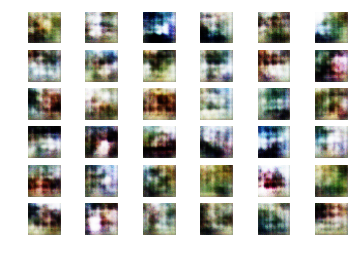

In [16]:
def plot_images(images, subplot_shape):
    plt.style.use('ggplot')
    fig, axes = plt.subplots(*subplot_shape)
    for image, ax in zip(images, axes.flatten()):
        image = image[np.array([2,1,0]),:,:]
        image = np.rollaxis(image / 2 + 0.5, 0, 3)
        ax.imshow(image, vmin=-1.0, vmax=1.0)
        ax.axis('off')
    plt.show()

noise = noise_sample(36)
images = G_output.eval({G_input: noise})
plot_images(images, subplot_shape=[6, 6])

Larger number of iterations should generate more realistic looking images.

## Model Creation (LS-GAN)

Since the generator and discriminator architectures of LS-GAN is the same as W-GAN, we will reuse the generator and the discriminator we defined for W-GAN. The main difference between W-GAN and LS-GAN is their loss function and optimizer they use. We redefine the training parameters for LS-GAN.

In [17]:
# training config
minibatch_size = 64
num_minibatches = 1000 if isFast else 20000
lr = 0.0001
momentum = 0.5
lambda_ = 0.0002 # lambda in LS-GAN loss function, controls the size of margin
weight_decay = 0.00005

### Build the graph
As we mentioned above, one of the differences between LS-GAN and W-GAN is there loss function. In `build_LSGAN_graph`, we should define the loss function for the generator and the discriminator. Another difference is that we do not do weight clipping in LS-GAN, so `clipped_D_parames` is no longer needed. Instead, we use weight decay which is mathematically equivalent to adding an l2 regularization in the optimizer.

In [18]:
def build_LSGAN_graph(noise_shape, image_shape, generator, discriminator):
    
    input_dynamic_axes = [C.Axis.default_batch_axis()]
    Z = C.input_variable(noise_shape, dynamic_axes=input_dynamic_axes)
    X_real = C.input_variable(image_shape, dynamic_axes=input_dynamic_axes)
    X_real_scaled = (X_real - 127.5) / 127.5

    # Create the model function for the generator and discriminator models
    X_fake = generator(Z)
    D_real = discriminator(X_real_scaled)
    D_fake = D_real.clone(
        method = 'share',
        substitutions = {X_real_scaled.output: X_fake.output}
    )
    
    G_loss = D_fake
    D_loss = C.element_max(D_real - D_fake + lambda_ * C.reduce_sum(C.abs(X_fake - X_real_scaled)), [0.])
    
    G_learner = C.adam(
            parameters = X_fake.parameters,
            lr = C.learning_rate_schedule(lr, C.UnitType.sample),
            momentum = C.momentum_schedule(momentum),
            variance_momentum = C.momentum_schedule(0.999),
            l2_regularization_weight=weight_decay,
            unit_gain=False,
            use_mean_gradient=True
    )
            
    D_learner = C.adam(
            parameters = D_real.parameters,
            lr = C.learning_rate_schedule(lr, C.UnitType.sample),
            momentum = C.momentum_schedule(momentum),
            variance_momentum = C.momentum_schedule(0.999),
            l2_regularization_weight=0.00005,
            unit_gain=False,
            use_mean_gradient=True
        )
    
    # Instantiate the trainers
    G_trainer = C.Trainer(X_fake,
                        (G_loss, None),
                        G_learner)
    D_trainer = C.Trainer(D_real,
                        (D_loss, None),
                        D_learner)

    return X_real, X_fake, Z, G_trainer, D_trainer

## Train the model
To train the LS-GAN model, we can just simply update the discriminator and the generator alternatively at each round.

In [19]:
def train_LSGAN(reader_train, generator, discriminator):
    X_real, X_fake, Z, G_trainer, D_trainer = \
        build_LSGAN_graph(g_input_dim, d_input_dim, generator, discriminator)
        
    # print out loss for each model for upto 25 times
    print_frequency_mbsize = num_minibatches // 25
    
    print("First row is Generator loss, second row is Discriminator loss")
    pp_G = C.logging.ProgressPrinter(print_frequency_mbsize)
    pp_D = C.logging.ProgressPrinter(print_frequency_mbsize)
    
    
    input_map = {X_real: reader_train.streams.features}

    for training_step in range(num_minibatches):
        # Train the discriminator and the generator alternatively
        Z_data = noise_sample(minibatch_size)
        X_data = reader_train.next_minibatch(minibatch_size, input_map)
        batch_inputs = {X_real: X_data[X_real].data, Z: Z_data}
        D_trainer.train_minibatch(batch_inputs)
        
        Z_data = noise_sample(minibatch_size)
        batch_inputs = {Z: Z_data}
        G_trainer.train_minibatch(batch_inputs)
        
        pp_G.update_with_trainer(G_trainer)
        pp_D.update_with_trainer(D_trainer)

    G_trainer_loss = G_trainer.previous_minibatch_loss_average
    return Z, X_fake, G_trainer_loss

In [20]:
reader_train = create_reader(train_file, True)

G_input, G_output, G_trainer_loss = train_LSGAN(reader_train,
                                          convolutional_generator,
                                          convolutional_discriminator)

Reading map file: c:\Data\CNTKTestData\Image\CIFAR\v0\tutorial201\train_map.txt
Generator input shape:  (100,)
h0 shape (256, 4, 4)
h1 shape (128, 8, 8)
h2 shape : (64, 16, 16)
h3 shape : (3, 32, 32)
Discriminator convolution input shape (3, 32, 32)
h0 shape : (64, 16, 16)
h1 shape : (128, 8, 8)
h2 shape : (256, 4, 4)
h3 shape : (1,)
First row is Generator loss, second row is Discriminator loss
 Minibatch[   1-  40]: loss = -0.029210 * 2560;
 Minibatch[   1-  40]: loss = 0.226002 * 2560;
 Minibatch[  41-  80]: loss = -0.144738 * 2560;
 Minibatch[  41-  80]: loss = 0.032180 * 2560;
 Minibatch[  81- 120]: loss = 0.273031 * 2560;
 Minibatch[  81- 120]: loss = 0.018019 * 2560;
 Minibatch[ 121- 160]: loss = 0.751740 * 2560;
 Minibatch[ 121- 160]: loss = 0.013435 * 2560;
 Minibatch[ 161- 200]: loss = 2.535229 * 2560;
 Minibatch[ 161- 200]: loss = 0.010941 * 2560;
 Minibatch[ 201- 240]: loss = 4.229947 * 2560;
 Minibatch[ 201- 240]: loss = 0.026397 * 2560;
 Minibatch[ 241- 280]: loss = 3.0402

In [21]:
# Print the generator loss 
print("Training loss of the generator is: {0:.2f}".format(G_trainer_loss))

Training loss of the generator is: 5.70


## Generating Fake (Synthetic) Images (LS-GAN)
Now that we have trained the LS-GAN model, we can create fake images simply by feeding random noise into the generator and displaying the outputs. Below are a few images generated from random samples. To get a new set of samples, you can re-run the last cell.

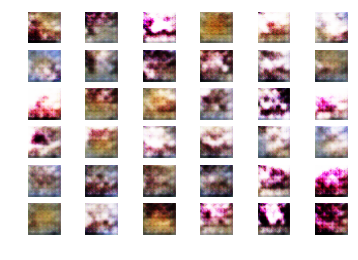

In [22]:
def plot_images(images, subplot_shape):
    plt.style.use('ggplot')
    fig, axes = plt.subplots(*subplot_shape)
    for image, ax in zip(images, axes.flatten()):
        image = image[np.array([2,1,0]),:,:]
        image = np.rollaxis(image / 2 + 0.5, 0, 3)
        ax.imshow(image, vmin=-1.0, vmax=1.0)
        ax.axis('off')
    plt.show()

noise = noise_sample(36)
images = G_output.eval({G_input: noise})
plot_images(images, subplot_shape=[6, 6])

Larger number of iterations should generate more realistic looking images. 